# Wave-pinned patterns

## References
AL Saadi, F. S., Champneys, A. R., & Jeffrey, M. R. (2024). Wave-
pinned patterns for cell polarity — a catastrophe theory explanation.
SIAM Journal on Applied Dynamical Systems, 23(1), 721-747.
https://doi.org/10.1137/22M1509758


## General polarity model

$$
\begin{aligned}
\frac{\partial A^*}{\partial t} &= \delta \frac{\partial^2 A^*}{\partial x^2} + F(A^*, A, B^*, B)\\
\frac{\partial A}{\partial t} &= \frac{\partial^2 A}{\partial x^2} - F(A^*, A, B^*, B)\\
\frac{\partial B^*}{\partial t} &= \delta \frac{\partial^2 B^*}{\partial x^2} + G(A^*, A, B^*, B)\\
\frac{\partial B}{\partial t} &= \frac{\partial^2 B}{\partial x^2} - G(A^*, A, B^*, B)
\end{aligned}
$$

## Kinetics

$$
\begin{aligned}
F(A^*, A, B^*, B) &= \left(\eta A^{*2} + \rho\right)A - (\alpha B^* + \mu)A^* \\
G(A^*, A, B^*, B) &= \left(\eta B^{*2} + \rho\right)B - (\alpha A^* + \mu)B^*
\end{aligned}
$$

## Reduction to ODE

$$
\begin{aligned}
S(x) &= \delta A^*(x) + A\\
u(x) &= \delta A^*(x) - A\\
E(x) &= \delta B^*(x) + B\\
u(x) &= \delta B^*(x) - B
\end{aligned}
$$

Substituting into the time independent model gives

$$
\begin{aligned}
\frac{\partial^2 S}{\partial x^2} &= 0,\\
\frac{\partial^2 u}{\partial x^2} &= -2F(u,S,v,E)\\
\frac{\partial^2 E}{\partial x^2} &= 0, \\
\frac{\partial^2 v}{\partial x^2} &= -2G(u,S,v,E)\\
\end{aligned}
$$

Note, $S$ and $E$ are decouple so treat them as parameters.

## Substituting Kinetics
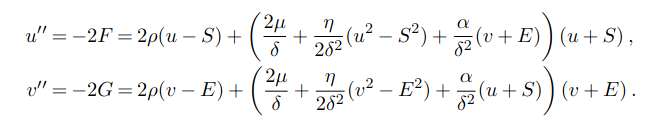

## Change of Variables to eliminate quadratic terms

Let $u=x-S/3$ and $v=y-E/3$.

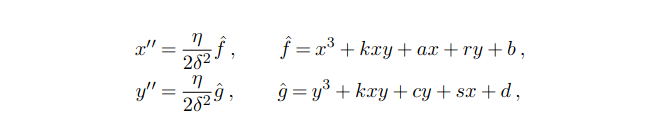

with parameters

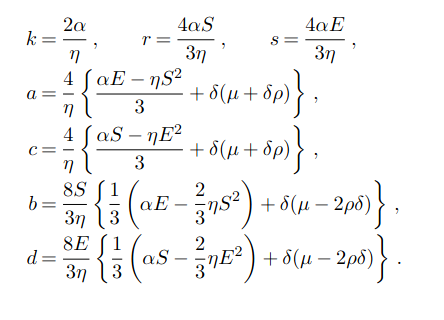

## Change of Variables exploiting symmetry

Let $X = x+y$ and $Y = x-y$ so he system becomes $(X^{\prime\prime},Y^{\prime\prime}) = \frac{\nu}{2\delta^2}(\hat{F},\hat{G})$

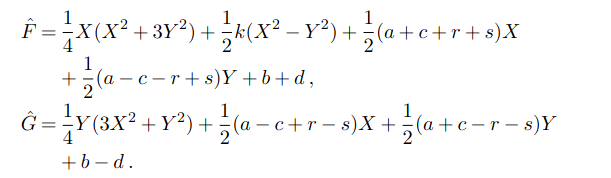


In [1]:
# parameters
const η = 2
const μ = 0.05
const ρ = 0.06
const α = 0.005
const δ = 0.08
const S = E = 0.0878;

In [2]:
# derived parameters
const k = 2α/η
const r = 4α*S/3η
const s = 4α*E/3η
const a = (4/η)*((α*E - η*S^2)/3 + δ*(μ + δ*ρ))
const c = (4/η)*((α*S - η*E^2)/3 + δ*(μ + δ*ρ))
const b = (8S/3η)*((1/3)*(α*E - (2/3)*η*S^2) + δ*(μ - 2*δ*ρ))
const d = (8E/3η)*((1/3)*(α*S - (2/3)*η*E^2) + δ*(μ - 2*δ*ρ));

In [3]:
# RHS
F_hat(X, Y) = (1/4)*X*(X^2 + 3*Y^2) + (1/2)*k*(X^2 - Y^2) + (1/2)*(a + c + r + s)*X + (1/2)*(a - c - r + s)*Y + b + d
G_hat(X, Y) = (1/4)*Y*(3*X^2 + Y^2) + (1/2)*(a - c + r - s)*X + (1/2)*(a + c - r - s)*Y + b - d;

# Phase Portrait

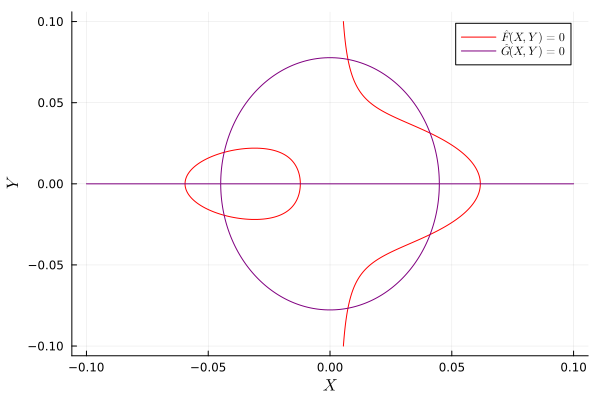

In [4]:
using Plots
using Contour
using LaTeXStrings

X = Y = range(-0.1, stop = 0.1, length = 500)


cl = levels(contours(X, Y, F_hat.(X, Y'), [0]))[1]
plot(coordinates(lines(cl)[1])..., label=L"\hat{F}(X, Y)=0", color="red")
plot!(coordinates(lines(cl)[2])..., label=nothing, color="red")
cl = levels(contours(X, Y, G_hat.(X, Y'), [0]))[1]
plot!(coordinates(lines(cl)[1])..., label=L"\hat{G}(X, Y)=0", color="purple")
plot!(coordinates(lines(cl)[2])..., label=nothing, color="purple")
xlabel!(L"X")
ylabel!(L"Y")

# Solving the initial boundary value problem

In [ ]:
using LinearAlgebra
using OrdinaryDiffEq: SplitODEProblem, solve, IMEXEuler
import SciMLOperators
using BlockDiagonals

# Reaction kinetics
F(A_star, A, B_star, B) = (η*A_star^2 + ρ)*A - (α*B_star + μ)*A_star
G(A_star, A, B_star, B) = (η*B_star^2 + ρ)*B - (α*A_star + μ)*B_star

t_span = (0, 10)
ℓ = 100  # domain is [-ℓ,ℓ]
n =  500 # number of cells
Δx = 2ℓ/n
Δx² = Δx^2
x_discrete = range(-ℓ, ℓ, n + 1)

A_star₀ = @. exp(-x_discrete^2)
A₀ = @. exp(-x_discrete^2)
B_star₀ = @. exp(-x_discrete^2)
B₀ = @. exp(-x_discrete^2)

u₀ = hcat(A_star₀, A₀, B_star₀, B₀);

In [24]:
function rhs!(dU, U, params, t)
    n, Δx² = params
    @inbounds begin
        for i in 1:4
            dU[1, i] = 2*(U[2, i] - U[1, i])
            dU[end, i] = 2*(U[end, i] - U[end - 1, i])
            for j in 2:(n - 1)
                dU[j, i] = U[j+1, i] - 2*U[j,i] + U[j-1, i]
            end
            if i % 2 != 0
                dU[:, i] *= δ
            end
        end
    end
    dU /= Δx²
    return nothing
end

function nl_rhs!(dU, U, params, t)
    dU .= 0
    return nothing
end

prob = SplitODEProblem(rhs!, nl_rhs!, u₀, t_span, (n, Δx²));

In [27]:
sol = solve(prob,
    IMEXEuler(),
    dt = 0.1,
    saveat = range(t_span..., length = 5));

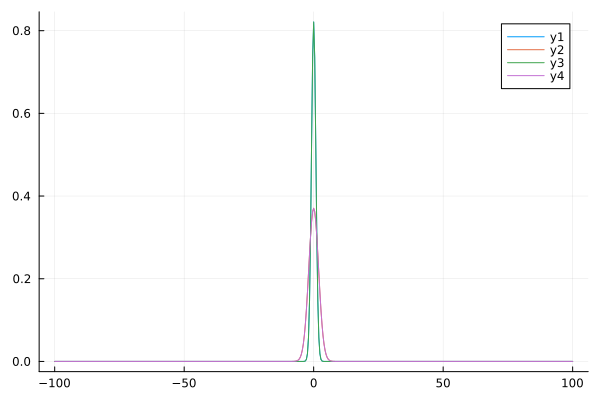

In [21]:
plot(x_discrete, sol.u[end][:, 1])
plot!(x_discrete, sol.u[end][:, 2])
plot!(x_discrete, sol.u[end][:, 3])
plot!(x_discrete, sol.u[end][:, 4])